# Example of component

In [1]:
import os
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import jax.numpy as jnp
import multihist as mh

import appletree as apt
from appletree.utils import get_file_path
from multihist import Hist1d, Histdd

XLA_PYTHON_CLIENT_PREALLOCATE is set to false
XLA_PYTHON_CLIENT_ALLOCATOR is set to platform
Cannot find aptext


/home/dantonmartin/.local/lib/python3.9/site-packages/appletree/__init__.py:51: UserWarning: You are running appletree on CPU, which usually results in low performance.
  warn(warning)


In [5]:
apt.__file__

'/home/dantonmartin/.local/lib/python3.9/site-packages/appletree/__init__.py'

In [2]:
# constrain the GPU memory usage

apt.set_gpu_memory_usage(0.2)

## Define component

### ComponentSim

In [3]:
# The components is associated with bins, so first we load bins
data = pd.read_csv(get_file_path("data_Neutron.csv"))
bins_cs1, bins_cs2 = apt.utils.get_equiprob_bins_2d(
    data[["num_s1_phd", "cs2"]].to_numpy(),
    [15, 15],
    order=[0, 1],
    x_clip=[0, 100],
    y_clip=[1e2, 1e4],
    which_np=jnp,
)

In [5]:
# Initialize component
er = apt.NR(bins=[bins_cs1, bins_cs2], bins_type="irreg")

In [12]:
# Deduce the workflow(datastructure)
er.deduce(data_names=["cs1", "cs2"], func_name="simulate")  # 'eff'(efficiency) is always simulated
er.rate_name = "er_rate"  # also we have to specify a normalization factor of the component

# Compile ER script
# This is meta-programing because  appletree can generate codes dynamically
er.compile()

NR_llh's map s2_cut_acc is using the parameter s2_cut_acc_sigma.
NR_llh's map s1_cut_acc is using the parameter s1_cut_acc_sigma.
NR_llh's map s1_eff_3f is static and not using any parameter.


In [13]:
# For reference, this is the compiled code, the function is stored in appletree.share._cached_functions
print(er.code)

from functools import partial
from jax import jit
from appletree.plugins import PositionSpectra
from appletree.plugins import FixedEnergySpectra
from appletree.plugins import ChargeYield
from appletree.plugins import DriftLoss
from appletree.plugins import NumberElectron
from appletree.plugins import S2LCE
from appletree.plugins import ElectronDrifted
from appletree.plugins import S2PE
from appletree.plugins import S2
from appletree.plugins import LightYield
from appletree.plugins import S1LCE
from appletree.plugins import NumberPhoton
from appletree.plugins import PhotonDetection
from appletree.plugins import S1PE
from appletree.plugins import S1
from appletree.plugins import S2CutAccept
from appletree.plugins import S1CutAccept
from appletree.plugins import S1ReconEff
from appletree.plugins import S2Threshold
from appletree.plugins import PositionRecon
from appletree.plugins import S2Correction
from appletree.plugins import S1Correction
from appletree.plugins import Eff
from appletre

### ComponentFixed

In [14]:
# Of course we have to load parameters(and their priors) in simulation

par_manager = apt.Parameter(get_file_path("nr_low.json"))
par_manager.sample_init()
parameters = par_manager.get_all_parameter()

In [15]:
parameters

{'gas_gain': 31.3,
 'drift_velocity': 0.0677,
 's2_threshold': 500.0,
 'g1': 0.14946783047307236,
 'g2': 15.209807898410835,
 'p_dpe': 0.23059254778142838,
 'elife_sigma': -0.040670699262600356,
 's1_eff_3f_sigma': -1.2110858477329205,
 's1_cut_acc_sigma': -1.6020670939499586,
 's2_cut_acc_sigma': -0.7721007561291306,
 't_ly': -0.07316822924863073,
 't_qy': 0.26539738630341353,
 'nr_rate': 2012.1782919754278}

## Simulation

In [25]:
# Really do the simulation

batch_size = int(1e3)
key = apt.randgen.get_key(seed=137)

key, (cs1, cs2, eff) = er.simulate(key, batch_size, parameters)

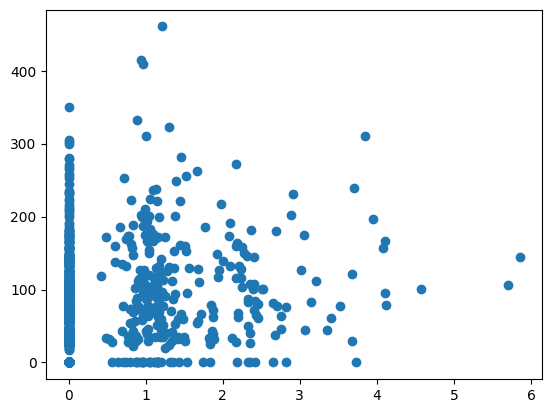

In [26]:
plt.plot(cs1, cs2, 'o')

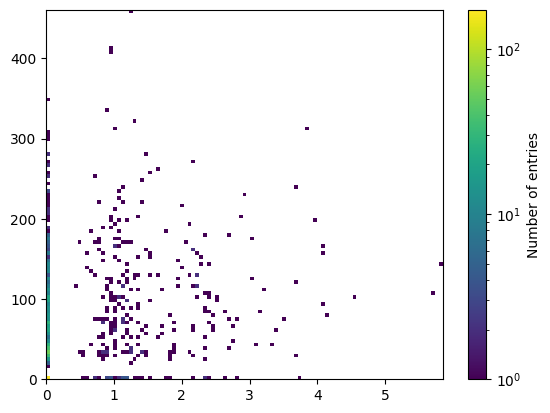

In [32]:
h = Histdd(cs1, cs2, bins = 101)
h.plot('log')
plt.show()

## Simulation and make equiprob hist

In [11]:
# Actually `simulate_hist` is just a wrapper of `simulate`

batch_size = int(1e6)
key = apt.randgen.get_key(seed=137)
key, h = er.simulate_hist(key, batch_size, parameters)

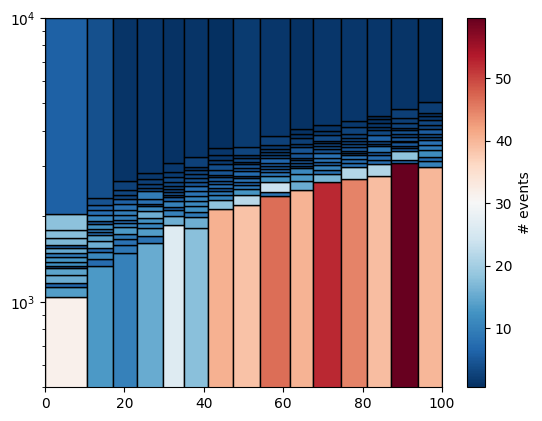

In [12]:
apt.utils.plot_irreg_histogram_2d(bins_cs1, bins_cs2, h, density=False)
plt.yscale("log")
plt.ylim(5e2, 1e4)
plt.show()

In [13]:
h = ac.simulate_hist(parameters)

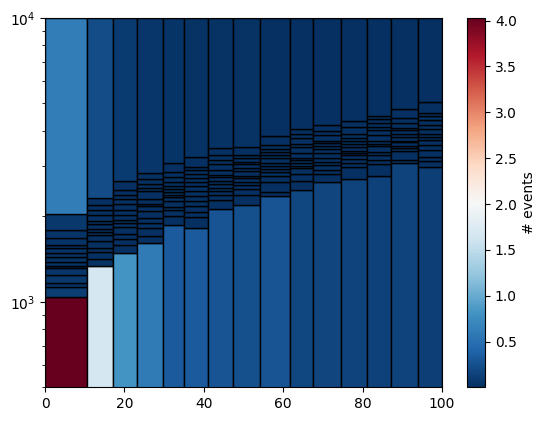

In [14]:
apt.utils.plot_irreg_histogram_2d(bins_cs1, bins_cs2, h, density=False)
plt.yscale("log")
plt.ylim(5e2, 1e4)
plt.show()

## Speed test

In [15]:
@apt.utils.timeit
def test(key, batch_size, parameters):
    return er.simulate_hist(key, batch_size, parameters)

In [16]:
@apt.utils.timeit
def benchmark():
    key = apt.randgen.get_key()
    for _ in range(100):
        key, _ = test(key, int(1e6), parameters)

In [17]:
benchmark()

 Function <benchmark> starts.
 Function <test> starts.
 Function <test> ends! Time cost = 2400.12 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 2493.61 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 2467.75 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 2298.71 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 2548.38 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 2486.91 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 2261.94 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 2388.15 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 2429.06 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 2689.71 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 2301.48 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 2714.10 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 2488.10 msec.
 Functio

KeyboardInterrupt: 